### <span style='color: blue'> **_Unveiling Ethereum's Price Dynamics: A Time Series Analysis and Forecasting_**</span>

__Author__: _HACINI Ahmed Djalal_

#### Abstract
This study investigates the price movements of Ethereum, a prominent cryptocurrency, using time series analysis. We leverage a comprehensive dataset encompassing Ethereum's closing, opening, high, and low prices for a four-year period (2019-2022) with a 15-minute time interval. Employing ARIMA (Autoregressive Integrated Moving Average) models, we delve into model specification, fitting, and diagnosis. Subsequently, we utilize the chosen ARIMA model to generate forecasts for future Ethereum prices. By analyzing the results, this research aims to shed light on the underlying patterns and trends in Ethereum's price behavior. Furthermore, the forecasting component offers valuable insights for investors, traders, and businesses navigating the dynamic cryptocurrency market.


## Introduction

This project delves into the ever-changing world of **Ethereum prices**. Ethereum, a popular cryptocurrency, has experienced significant fluctuations in value since its inception. Understanding 
these price movements can be crucial for various stakeholders, including investors, traders, and businesses.

To facilitate this analysis, we've compiled a comprehensive **dataset** encompassing Ethereum's price history. This dataset specifically covers the years between __2019-11-27__ and __2022-03-16__, providing a detailed look at price movements over a four-year period.

The dataset offers granular details by capturing price data every __15 minutes__. This high frequency allows for a meticulous examination of even minor price shifts. With a total of __80,587 data points__, the dataset presents a substantial collection for researchers to explore.

Investigating Ethereum's price movements is worthwhile for several reasons. Firstly, understanding price fluctuations can inform investment decisions. By analyzing historical trends and patterns, investors can make more informed choices about buying, selling, or holding Ethereum.

Secondly, examining price movements can benefit businesses that accept Ethereum as payment. Recognizing potential price swings can help them prepare for fluctuations and make informed decisions regarding transactions.

Finally, this data can contribute to the development of more sophisticated trading models and algorithms. By incorporating historical price data, these models can potentially predict future price movements with greater accuracy, aiding traders in navigating the cryptocurrency market.

In essence, this dataset serves as a valuable tool for anyone interested in Ethereum's price behavior. By delving into this data, we can gain valuable insights into the cryptocurrency market and its potential future direction.


    Data Source:
 This dataset is sourced from Kaggle: https://www.kaggle.com/datasets/glebkirichenko/price-ethereum, a public platform for sharing and exploring machine learning datasets.

## Analysis and Model Specification

First, lets load and take a first glance at the data

In [2]:
file_path <- "data/ETHUSDT_PERP_15m.csv"
data <- read.csv(file_path)
head(data)

,dateTime,open,high,low,close,volume
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-11-27 14:15:00,148.00,148.08,146.80,147.38,2693.24
2,2019-11-27 14:30:00,147.37,147.66,147.15,147.28,2355.46
3,2019-11-27 14:45:00,147.48,147.66,146.90,147.65,2584.54
4,2019-11-27 15:00:00,147.61,147.98,147.32,147.95,1876.29
5,2019-11-27 15:15:00,147.97,148.71,147.79,148.69,2407.68
6,2019-11-27 15:30:00,148.67,151.39,148.56,151.16,2471.09


We see that the names of the columns that are _Close, open, high, and low_ refer to the trading price of Ethereum over a specific period.

    Open: The price at which the first Ethereum trade occurred in the chosen timeframe (e.g., today, this week, this month).
    High: The highest price at which Ethereum was traded during the timeframe.
    Low: The lowest price at which Ethereum was traded during the timeframe.
    Close: The price at which the last Ethereum trade occurred within the timeframe.

For the purpose of the analysis, we would like to focus on __Close Price__ so that we can understand the final market sentiment and price after a trading session concludes.

In [158]:
# Keep only close price and timestamp columns and convert it to time series object
eth_data <- data[, c("dateTime", "close")]
eth_data$dateTime <- strptime(eth_data$dateTime, "%Y-%m-%d %H:%M:%S")
head(eth_data)

,dateTime,close
,<dttm>,<dbl>
1,2019-11-27 14:15:00,147.38
2,2019-11-27 14:30:00,147.28
3,2019-11-27 14:45:00,147.65
4,2019-11-27 15:00:00,147.95
5,2019-11-27 15:15:00,148.69
6,2019-11-27 15:30:00,151.16


In [156]:
# splitting the data into training and testing sets
train_size <- 0.8
train_size_index <- floor(train_size * nrow(eth_data))
train_data <- eth_data[1:train_size_index, ]
test_data <- eth_data[(train_size_index + 1):nrow(eth_data), ]


In [157]:
plot(eth_data$dateTime ,eth_data$close, type = "l", xlab = "Time", ylab = "Price", main = "ETH/USDT Price", col="blue")

ERROR: Error in train_data$dateTime: $ operator is invalid for atomic vectors


#### __Interpreting the plot__
The plot displays the price over time, showing significant movements within the intervals. There is an evident upward *__trend__* especially in the middle of the observed period where the price peaks. This *__trend__* suggests that the time series might not be *__stationary__*, as the statistical properties of the series, like the *__mean__* seems to be *__non-constant__* over time. Trend-stationarity would imply that fluctuations around a deterministic trend do not have a unit root, but this does not seem to be the case here (a statistical test will be conducted later).


The *__variance__* appears to be relatively *__small__*, but we haven't yet established if it's *__constant__* throughout the time series. Though, we can see some variation over time, although the changes aren't pronounced. This could suggest that while there is some fluctuation in the variance, it may not be substantial enough to deem the *__heteroscedasticity__*.

#### 

#### __Stationarity__ ####

Since both ACF and PACF assume stationarity of the underlying time series. Staionarity can be checked by performing an *__Augmented Dickey-Fuller (ADF) test__*:

        p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
        p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In order to check for stationarity, let's define a the following funtion that performs the ADF test:

In [8]:
library(forecast)
library(tseries)
library(TSA)

Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar




In [18]:
check_stationarity <- function(data) {
    result <- adf.test(data)
    cat('ADF Statistic:', result$statistic, '\n')
    cat("p-value", result$p.value, '\n')
    cat('Lag order:', result$parameter, '\n')
    if (result$p.value < 0.05 ) {
        cat('d stationary\n')
    } else {
        cat('The data is not stationary\n')
    }
}

In [31]:
check_stationarity(train_data$close)

ADF Statistic: -2.535115 
p-value 0.350788 
Lag order: 40 
The data is not stationary


*__p-value__*:
 The high p-value of 0.350788 signifies a failure to reject the null hypothesis at commonly used significance levels (0.05). This further bolsters the evidence for non-stationarity. Hence the visual inspection of *__non-stationarity__* in the time series plot aligns with the findings from the *__ADF test__*.

 _Note_: The *__Lag order__* of 40 might seem to be relatively high number of past values in the ADF regression model, but this is due to the fact that data lenght is quite large taking into consideration a 15min time frame. If we try to examine e.g 200 data points we will have a lag order of 5 which seems to be reasonable.

##### Achieving Stationarity #####
To proceed with the analysis and generate reliable forecasts, it is crucial to address the non-stationarity issue. Common approaches include differencing to remove trends (detrending). By transforming the data to achieve stationarity, we can establish a more robust foundation for the analysis and produce more accurate forecasts of Ethereum prices.

In [37]:
# Checking the number of differences required to make the data stationary
print(ndiffs(train_data$close))

[1] 1


In [38]:
# As it suggests, we will take the first difference of the data
train_diff <- diff(train_data$close)

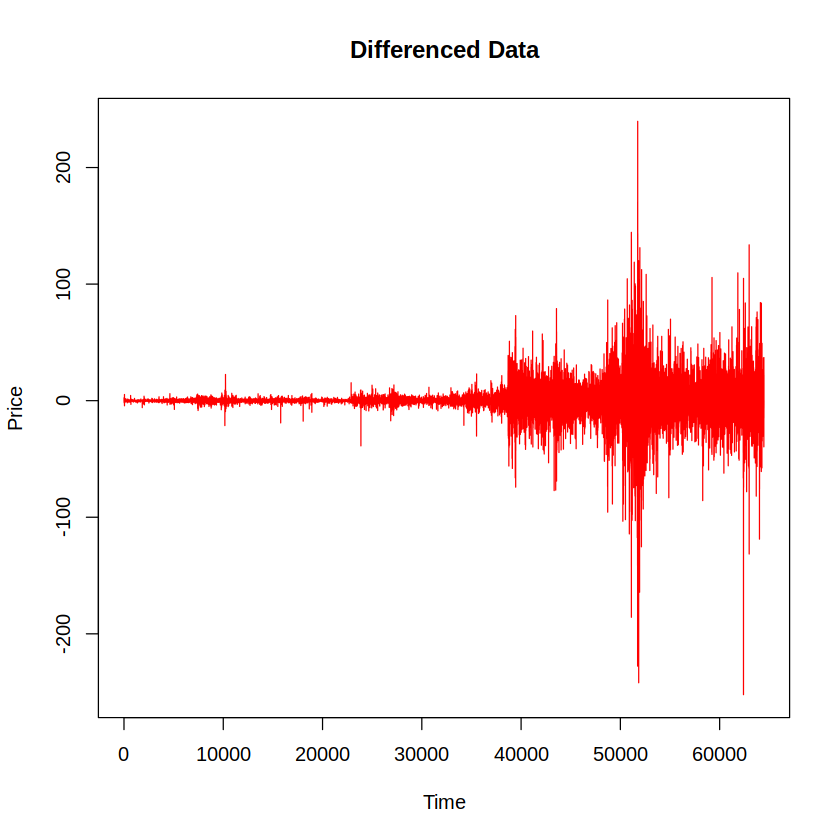

In [41]:
# Now, let's plot the differenced data and check if it is stationary
plot(train_diff, type = "l", xlab = "Time", ylab = "Price", main = "Differenced Data", col="red")

We can see that the 1st difference has removed the trend and brought our data to seem stationary
However, the variance exhibists a variation accross the dataset which indicates a *__heteroscedasticity__*.


#### Variance Stabilization ####
In time series, the process could have a non-constant variance and if the variance changes with time the process is nonstationary.
One common approach to suppress some of the variance is to use *__The Box-Cox transformation__* which is a family of power transformations indexed by a parameter lambda. Whenever we use this technique the parameter needs to be estimated from the data.
This technique must be applied even before taking the 1st difference to remove the trend.

In [42]:
λ <- BoxCox.lambda(train_data$close)
λ

[1] -0.008463963

In [43]:
#We transform both train and test data based on the best lambda value
trans_train <- BoxCox(train_data$close, λ)
trans_test <- BoxCox(test_data$close, λ)

Now after achieving a *__constant variance__* we can apply the differencing technique safely

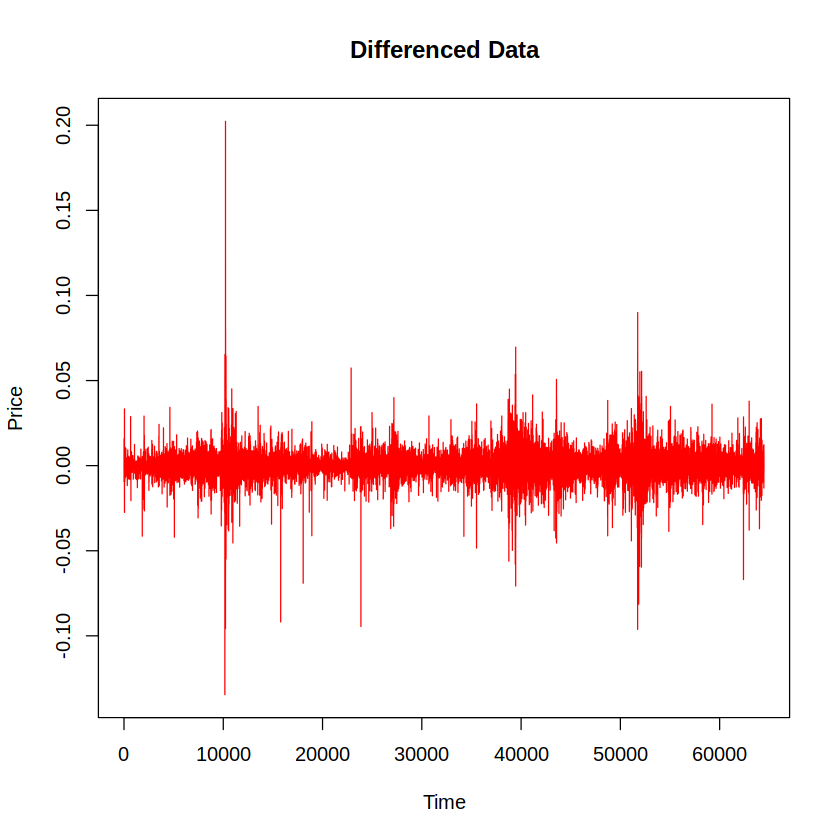

In [45]:
eth_train_data <- diff(trans_train)
plot(eth_train_data, type = "l", xlab = "Time", ylab = "Price", main = "Differenced Data", col="red")

We can see now from the plot that we have a *__constant variance__* and a *__zero mean__*

Let's check again the ADF stationarity test:

In [46]:
check_stationarity(eth_train_data)

Warning message in adf.test(data):
“p-value smaller than printed p-value”


ADF Statistic: -39.2674 
p-value 0.01 
Lag order: 40 
The data is stationary


Voila !! The ADF test result a strong evidence of stationarity. Hence, we can take the next step of specifying the candidate models without any worries about model prameters bias

To begin with, let's check the ACF and PACF functions 

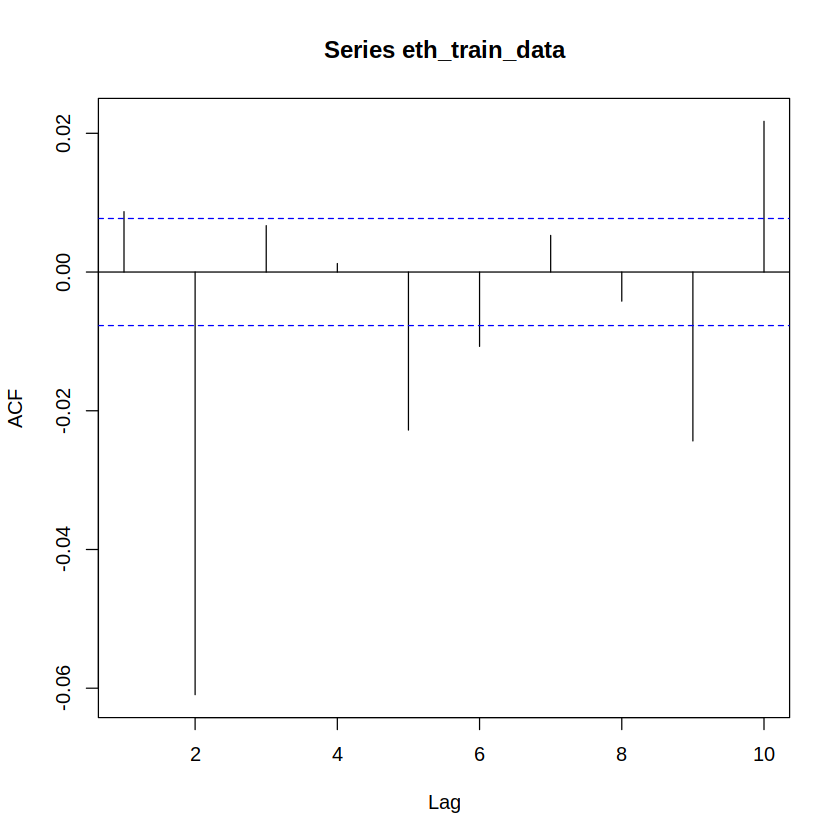

In [55]:
acf(eth_train_data, lag.max = 10)

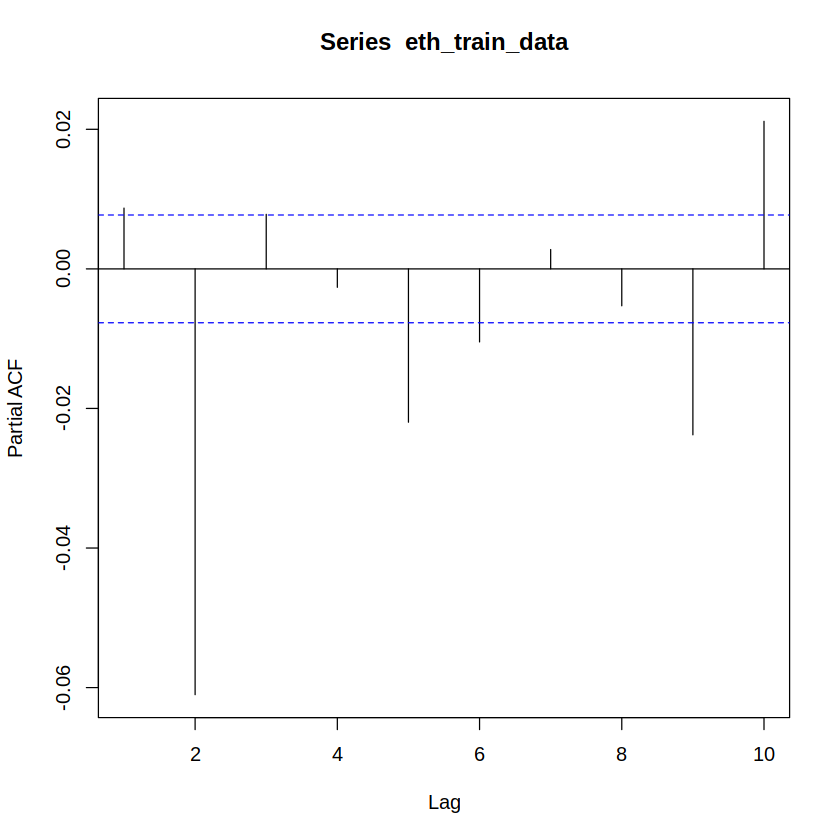

In [56]:
pacf(eth_train_data, lag.max = 10)

Observations: The ACF function

Candidate: ARIMA(2, 0, 2)

In [146]:
auto.arima(eth_train_data)
auto.arima(train_data$close)

Series: eth_train_data 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ma1  mean
      -0.1108  -0.060  0.1205     0
s.e.   0.0584   0.004  0.0584     0

sigma^2 = 2.972e-05:  log likelihood = 244523.6
AIC=-489037.2   AICc=-489037.2   BIC=-488991.9

Series: train_data$close 
ARIMA(1,1,2) 

Coefficients:
         ar1      ma1      ma2
      0.3667  -0.3458  -0.0441
s.e.  0.0868   0.0868   0.0040

sigma^2 = 99.06:  log likelihood = -239613.4
AIC=479234.7   AICc=479234.7   BIC=479271

`auto.arima` function returns best ARIMA model according to either AIC or BIC
     value. The function conducts a search over the possible models

### Fitting and Diagnosis ###

In [118]:
arima_model.1 <- arima(eth_train_data, order = c(2, 0, 1))
summary(arima_model.1)

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”
Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = eth_train_data, order = c(2, 0, 1), seasonal = list(order = c(2, 0, 
    1)))

Coefficients:
         ar1      ar2    ma1    sar1     sar2   sma1  intercept
      0.0018  -0.0306  0.003  0.0018  -0.0306  0.003          0
s.e.  0.0652   0.0031    NaN  0.0652   0.0031    NaN          0

sigma^2 estimated as 2.972e-05:  log likelihood = 244522,  aic = -489030

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

In [59]:
arima_model.2 <- arima(eth_train_data, order = c(2, 0, 2))
summary(arima_model.2)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = eth_train_data, order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1      ma2  intercept
      -0.0554  -0.0089  0.0650  -0.0518          0
s.e.   0.3732   0.4351  0.3728   0.4383          0

sigma^2 estimated as 2.972e-05:  log likelihood = 244523,  aic = -489035.9

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

Interprete the model estimators

In [164]:
arima_model.3 <- arima(trans_train, order = c(1, 1, 2))
summary(arima_model.3)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = trans_train, order = c(1, 1, 2))

Coefficients:
         ar1     ma1      ma2
      0.0043  0.0055  -0.0612
s.e.  0.0651  0.0650   0.0040

sigma^2 estimated as 2.972e-05:  log likelihood = 244520,  aic = -489034.1

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

#### **Residuals Analysis**
Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In [165]:
rsds <- arima_model.3$residuals

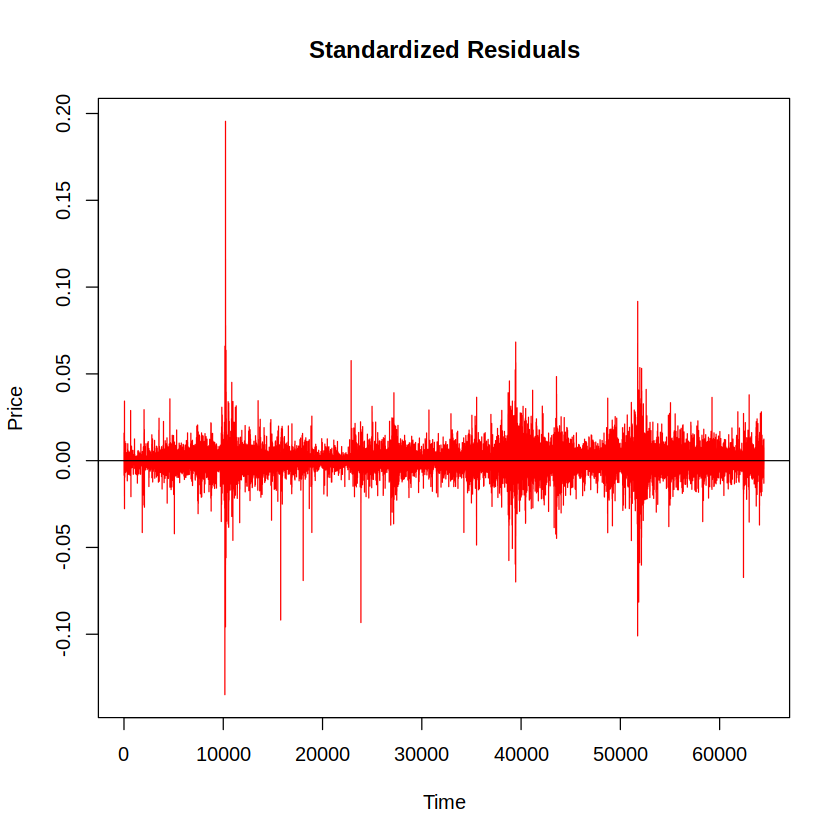

logical(0)

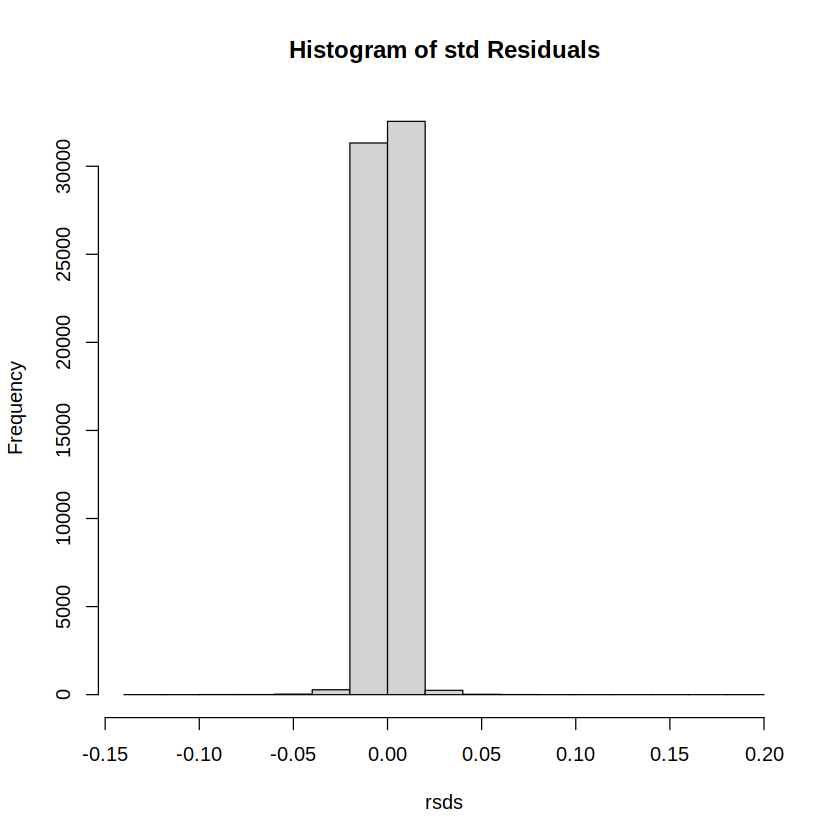

In [166]:
#plotting the residuals
plot(rsds, type = "l", xlab = "Time", ylab = "Price", main = "Standardized Residuals", col="red")
abline(h=0) > hist(rsds, main="Histogram of std Residuals")

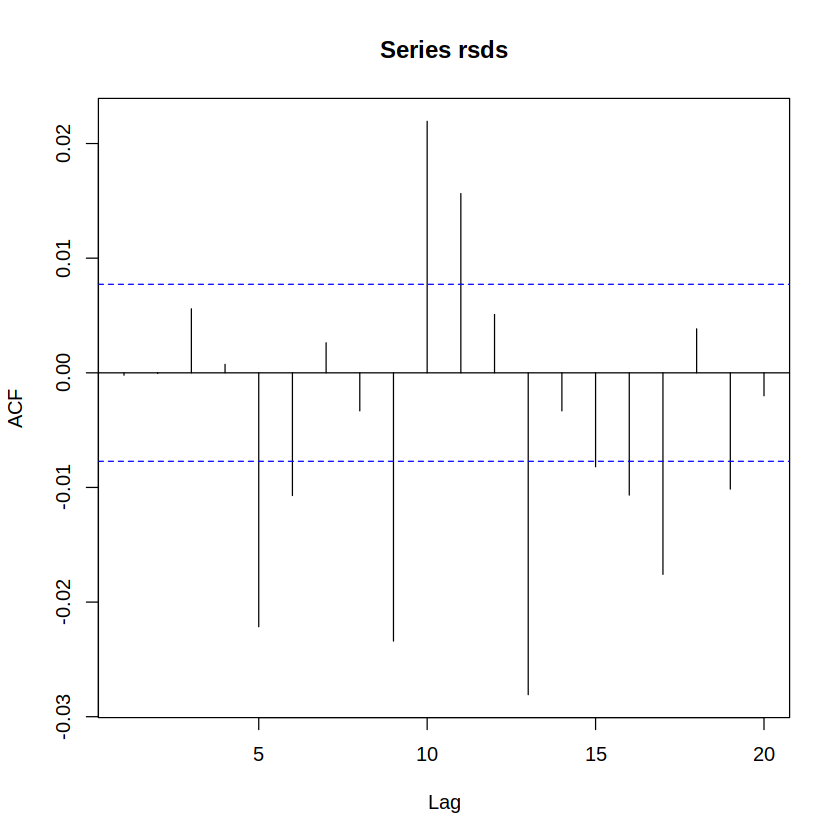

In [167]:
acf(rsds, lag.max = 20)

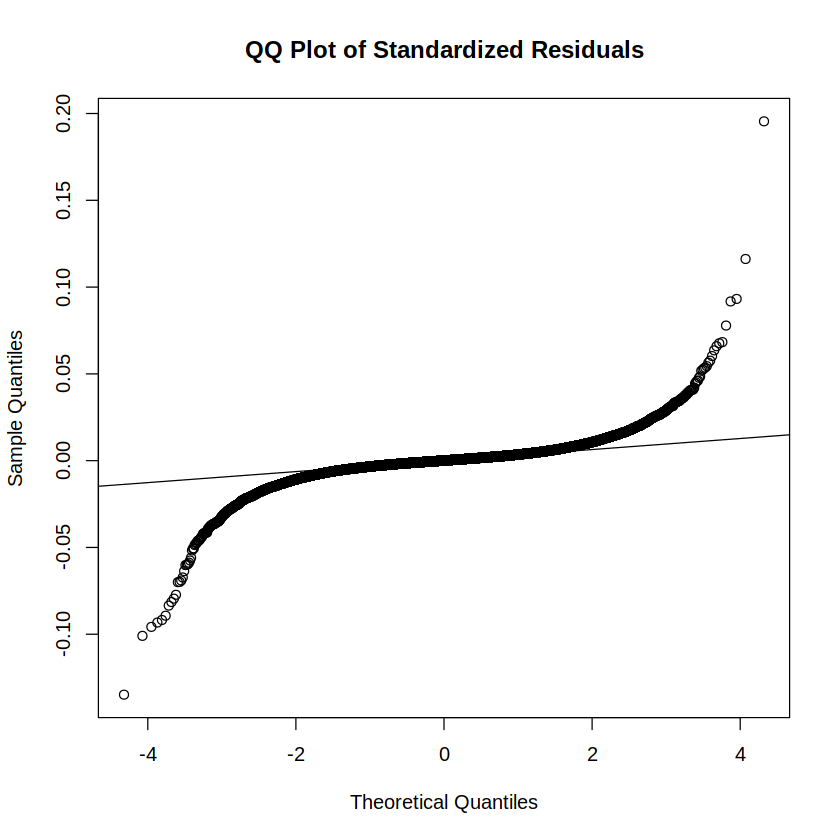

In [169]:
qqnorm(rsds, main= "QQ Plot of Standardized Residuals")
qqline(rsds)

In [174]:
#perform shapiro test of normality
shapiro.test(arima_model.3$residuals[1:5000])> runs(arima_model.3$residuals)

ERROR: Error in if (pvalue > 0.5) pvalue <- 1 - pvalue: missing value where TRUE/FALSE needed


Since your p-value is less than 0.05, you have evidence to suggest your data deviates from a normal distribution

_Note_: Shapiro.test expects only yp to 5000 data points, hence, we would like to use Anderson-Darling normality test

In [170]:
library(nortest)
ad.test(arima_model.3$res)


	Anderson-Darling normality test

data:  arima_model.3$res
A = 1960.4, p-value < 2.2e-16


In [171]:
runs.test(arima_model.3$res)

ERROR: Error in runs.test(arima_model.3$res): x is not a factor


### Forecasting ###
Having successfully addressed the non-stationarity in our Ethereum price data, we can now proceed to the forecasting stage. This stage involves utilizing our candidate models to predict future price movements

In [77]:
length(trans_test)

[1] 16119

In [79]:
#forecast data using ARIMA(2,0,1) model
arima_2.0.1_preds <- predict(arima_model.1)

In [80]:
#forecast data using ARIMA(2,0,2) model
arima_2.0.2_preds <- predict(arima_model.2)

In [134]:
# Applying the same Box-Cox transformation to the original data to see the forecast
eth_data_ts <- BoxCox(eth_data$close, lambda=λ)

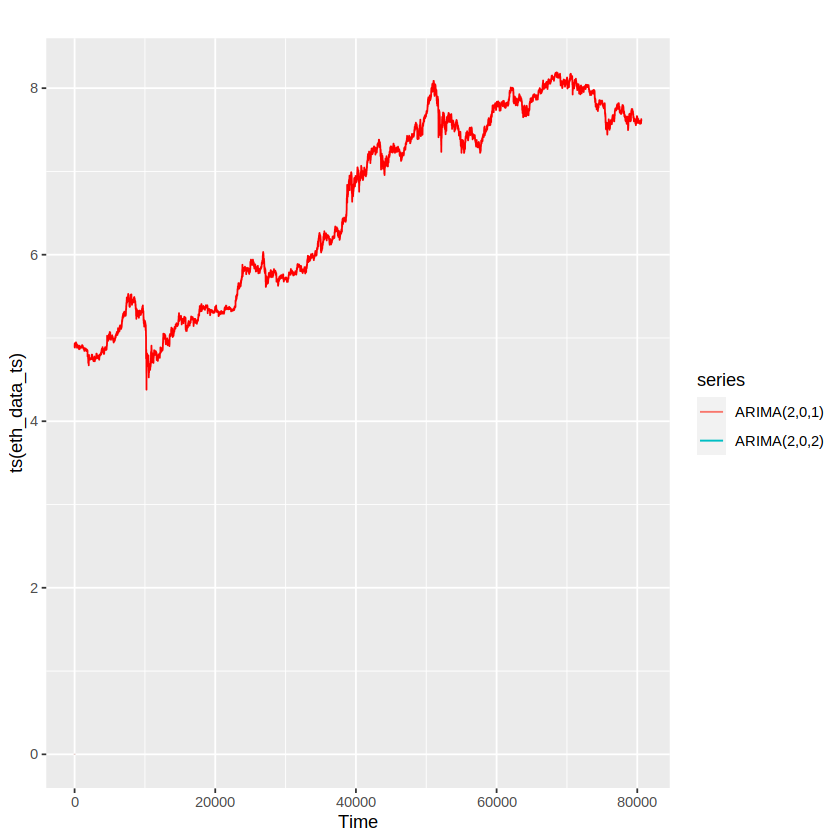

In [141]:
autoplot(ts(eth_data_ts), col="red") +
autolayer(ts(arima_2.0.1_preds), series = "ARIMA(2,0,1)", alpha=1) +
autolayer(ts(arima_2.0.2_preds), series = "ARIMA(2,0,2)", alpha=.3)

In [144]:
accuracy(ts(arima_2.0.1_preds), ts(eth_data_ts))
accuracy(ts(arima_2.0.2_preds), ts(eth_data_ts))

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”


ERROR: Error in testaccuracy(object, x, test, d, D): Unknown list structure
